# Tiền xử lý dữ liệu:

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import preprocessor as p
import seaborn as sns

## Thu thập thông tin

In [2]:
file_path = "Car details v3.csv"
dp = p.DataPreprocessor()
dp = p.DataPreprocessor.read_file(file_path)
dp.set_target("selling_price")

## Kiểm tra dữ liệu đầu vào

In [3]:
print(dp.df.head())
print("-----------Thông tin:-----------")
dp

                           name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250N

None

Các vấn đề:   
* Có thể có các dòng trùng lặp.
* Một số cột số vẫn còn đơn vị.
* Cột torque phải tách cột để xử lý.
* Nên tạo cột mới "age" từ cột year để có ý nghĩa hơn.
* Chia cột số và cột phân loại.
* Các cột còn giá trị bị thiếu.
* Đánh giá ngoại lai của các cột số.
* Chuẩn hóa dữ liệu số.
* Chuyển dữ liệu phân loại từ văn bản về số.

### Xử lý giá trị trùng lặp

In [4]:
# Đếm số dòng có giá trị trùng lặp và xuất ra đã sắp xếp
duplicate_counts = dp.df.duplicated().sum()
print(f"Số dòng trùng lặp: {duplicate_counts}")
duplicate_rows = dp.df[dp.df.duplicated(keep=False)]
df_sorted = duplicate_rows.sort_values(by=dp.df.columns.tolist())
print(df_sorted)

Số dòng trùng lặp: 1202
                                      name  year  selling_price  km_driven  \
1977  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
7324  Audi Q3 2.0 TDI Quattro Premium Plus  2017        2825000      22000   
2129               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
7775               Audi Q5 3.0 TDI Quattro  2014        1850000      76131   
131             Audi Q5 35TDI Premium Plus  2018        3975000      31800   
...                                    ...   ...            ...        ...   
6693        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
6963        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
7862        Volvo XC40 D4 Inscription BSIV  2019        3800000      20000   
145                 Volvo XC40 D4 R-Design  2018        3400000      22000   
3251                Volvo XC40 D4 R-Design  2018        3400000      22000   

        fuel seller_type transmission  

Các dòng trùng lặp đơn giản là bị lặp lại dữ liệu, đơn giản chỉ cần xóa các dòng trùng lặp.   
Bên cạnh đó có các dòng có name trùng nhau, nhưng các cột còn lại thì lại khác nên vẫn có ý nghĩa thống kê.

In [5]:
# Xóa các hàng trùng lặp
dp.remove_duplicates()
dp.df.info()

Đã xóa 1202 hàng trùng lặp.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   year           6926 non-null   int64  
 2   selling_price  6926 non-null   int64  
 3   km_driven      6926 non-null   int64  
 4   fuel           6926 non-null   object 
 5   seller_type    6926 non-null   object 
 6   transmission   6926 non-null   object 
 7   owner          6926 non-null   object 
 8   mileage        6718 non-null   object 
 9   engine         6718 non-null   object 
 10  max_power      6721 non-null   object 
 11  torque         6717 non-null   object 
 12  seats          6718 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 703.6+ KB


### Xử lý các cột có định dạng chưa chuẩn

Cột torque chưa 2 thông số về giá trị mô-men xoán và vòng tua máy.   
-> Tách thành 2 cột để dễ tính toán tham khảo, chuyển về cùng 1 đơn vị.

In [6]:
# Tách cột torque thành torque_value (giá trị Nm) và torque_rpm (vòng tua tương ứng vòng/phút)
for idx, val in dp.df["torque"].items():
    s = str(val).lower()
    # Lấy đơn vị của value
    unit_match = re.search(r"(nm|kgm)", s)
    # Lấy tất cả các số trong chuỗi
    numbers = re.findall(r"\d+(?:\.\d+)?", s)
    if numbers:
        torque_value = float(numbers[0].replace(",", ""))
        if unit_match and unit_match.group(1) == "kgm":
            # Chuyển kgm sang Nm (1 kgm = 9.80665 Nm)
            torque_value = torque_value * 9.80665
        dp.df.at[idx, "torque_value"] = torque_value
        # Lấy rpm là trung bình của những số còn lại
        if len(numbers) > 1:
            rpm_values = [float(n.replace(",", "")) for n in numbers[1:]]
            torque_rpm = sum(rpm_values) / len(rpm_values)
            dp.df.at[idx, "torque_rpm"] = int(torque_rpm)
        else:
            dp.df.at[idx, "torque_rpm"] = np.nan
    else:
        dp.df.at[idx, "torque_value"] = np.nan
        dp.df.at[idx, "torque_rpm"] = np.nan
dp.df["torque_value"] = pd.to_numeric(dp.df["torque_value"], errors="coerce")
dp.df["torque_rpm"] = pd.to_numeric(dp.df["torque_rpm"], errors="coerce")

print(dp.df[["torque", "torque_value", "torque_rpm"]].head())

                     torque  torque_value  torque_rpm
0            190Nm@ 2000rpm    190.000000      2000.0
1       250Nm@ 1500-2500rpm    250.000000      2000.0
2     12.7@ 2,700(kgm@ rpm)    124.544455       351.0
3  22.4 kgm at 1750-2750rpm    219.668960      2250.0
4     11.5@ 4,500(kgm@ rpm)    112.776475       252.0


In [7]:
# Xóa cột torque gốc
dp.df.drop(columns=["torque"], inplace=True)
dp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   year           6926 non-null   int64  
 2   selling_price  6926 non-null   int64  
 3   km_driven      6926 non-null   int64  
 4   fuel           6926 non-null   object 
 5   seller_type    6926 non-null   object 
 6   transmission   6926 non-null   object 
 7   owner          6926 non-null   object 
 8   mileage        6718 non-null   object 
 9   engine         6718 non-null   object 
 10  max_power      6721 non-null   object 
 11  seats          6718 non-null   float64
 12  torque_value   6717 non-null   float64
 13  torque_rpm     6713 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 757.7+ KB


None

Các cột mileage, engine, max_power còn chứa đơn vị (các đơn vị giống nhau).   
-> Xóa đơn vị đó.

In [8]:
# Xóa đơn vị các cột mileage, engine, max_power, gặp khoảng giá trị thì lấy giá trị trung bình
def extract_numeric(value):
    s = str(value).lower()
    # Lấy tất cả các số trong chuỗi
    numbers = re.findall(r"\d+(?:\.\d+)?", s)
    if not numbers:
        return np.nan
    elif len(numbers) == 1:
        return float(numbers[0].replace(",", ""))
    else:
        # Nếu có khoảng giá trị, lấy trung bình
        num_values = [float(n.replace(",", "")) for n in numbers]
        return sum(num_values) / len(num_values)
dp.df["mileage"] = dp.df["mileage"].apply(extract_numeric)
dp.df["engine"] = dp.df["engine"].apply(extract_numeric)
dp.df["max_power"] = dp.df["max_power"].apply(extract_numeric)
print(dp.df[["mileage", "engine", "max_power"]].head())

   mileage  engine  max_power
0    23.40  1248.0      74.00
1    21.14  1498.0     103.52
2    17.70  1497.0      78.00
3    23.00  1396.0      90.00
4    16.10  1298.0      88.20


## Khám phá và tiền xử lý dữ liệu

### Tạo cột mới (age từ year)

In [9]:
# Tạo cột age từ year
import datetime
current_year = datetime.datetime.now().year
dp.df["age"] = current_year - dp.df["year"]
print(dp.df[["year", "age"]].head())

   year  age
0  2014   11
1  2014   11
2  2006   19
3  2010   15
4  2007   18


In [10]:
# Xóa cột year
dp.df.drop(columns=["year"], inplace=True)
dp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6926 entries, 0 to 6925
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6926 non-null   object 
 1   selling_price  6926 non-null   int64  
 2   km_driven      6926 non-null   int64  
 3   fuel           6926 non-null   object 
 4   seller_type    6926 non-null   object 
 5   transmission   6926 non-null   object 
 6   owner          6926 non-null   object 
 7   mileage        6718 non-null   float64
 8   engine         6718 non-null   float64
 9   max_power      6720 non-null   float64
 10  seats          6718 non-null   float64
 11  torque_value   6717 non-null   float64
 12  torque_rpm     6713 non-null   float64
 13  age            6926 non-null   int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 757.7+ KB


None

### Tách loại cột để khám phá và tiền xử lý

In [11]:
# Phân loại cột số và cột phân loại
dp.infer_column_types()
print("Cột số:", dp.numeric_cols)
print("Cột phân loại:", dp.categorical_cols)

Cột số: ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque_value', 'torque_rpm', 'age']
Cột phân loại: ['fuel', 'seller_type', 'transmission', 'owner', 'seats']


In [12]:
dp.df.describe()

,selling_price,km_driven,mileage,engine,max_power,seats,torque_value,torque_rpm,age
count,6.926000e+03,6.926000e+03,6718.00000,6718.000000,6720.000000,6718.000000,6717.000000,6713.000000,6926.000000
mean,5.172707e+05,7.399568e+04,19.46531,1430.891337,87.726919,5.434653,174.684585,2725.053031,11.579700
std,5.197670e+05,5.835810e+04,4.04915,493.493277,31.771619,0.984230,106.876249,1093.163808,4.078286
min,2.999900e+04,1.000000e+00,0.00000,624.000000,0.000000,2.000000,47.071920,1.000000,5.000000
25%,2.500000e+05,4.000000e+04,16.80000,1197.000000,67.100000,5.000000,110.000000,2000.000000,8.000000
50%,4.000000e+05,7.000000e+04,19.44000,1248.000000,81.830000,5.000000,160.000000,2375.000000,11.000000
75%,6.335000e+05,1.000000e+05,22.50000,1498.000000,100.000000,5.000000,200.055660,3550.000000,14.000000
max,1.000000e+07,2.360457e+06,42.00000,3604.000000,400.000000,14.000000,1863.263500,5000.000000,42.000000


2 cột mileage và max_power có min là 0 -> vô lý.   
Nên xóa các dòng đó.

In [13]:
# Xóa các dòng có giá trị cột mileage và max_power là 0
dp.df = dp.df[(dp.df["mileage"] != 0) & (dp.df["max_power"] != 0)].reset_index(drop=True)
dp.df.describe()

,selling_price,km_driven,mileage,engine,max_power,seats,torque_value,torque_rpm,age
count,6.908000e+03,6.908000e+03,6703.000000,6703.000000,6702.000000,6703.000000,6702.000000,6698.000000,6908.000000
mean,5.169736e+05,7.402685e+04,19.508869,1430.612860,87.765621,5.436521,174.653469,2725.631532,11.577446
std,5.187974e+05,5.840365e+04,3.947453,493.040661,31.703000,0.983354,106.811075,1093.654997,4.079306
min,2.999900e+04,1.000000e+00,9.000000,624.000000,32.800000,4.000000,47.071920,1.000000,5.000000
25%,2.500000e+05,4.000000e+04,16.800000,1197.000000,68.000000,5.000000,110.815145,2000.000000,8.000000
50%,4.000000e+05,7.000000e+04,19.490000,1248.000000,81.830000,5.000000,160.000000,2375.000000,11.000000
75%,6.325000e+05,1.000000e+05,22.540000,1498.000000,100.000000,5.000000,200.055660,3550.000000,14.000000
max,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000,1863.263500,5000.000000,42.000000


### Xử lý dữ liệu missing

In [14]:
# Xử lý dữ liệu missing
dp.fill_missing(numeric_method="median", categorical_method="mode")
dp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6908 entries, 0 to 6907
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6908 non-null   object 
 1   selling_price  6908 non-null   int64  
 2   km_driven      6908 non-null   int64  
 3   fuel           6908 non-null   object 
 4   seller_type    6908 non-null   object 
 5   transmission   6908 non-null   object 
 6   owner          6908 non-null   object 
 7   mileage        6908 non-null   float64
 8   engine         6908 non-null   float64
 9   max_power      6908 non-null   float64
 10  seats          6908 non-null   float64
 11  torque_value   6908 non-null   float64
 12  torque_rpm     6908 non-null   float64
 13  age            6908 non-null   int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 755.7+ KB


None

### Phân phối của các cột

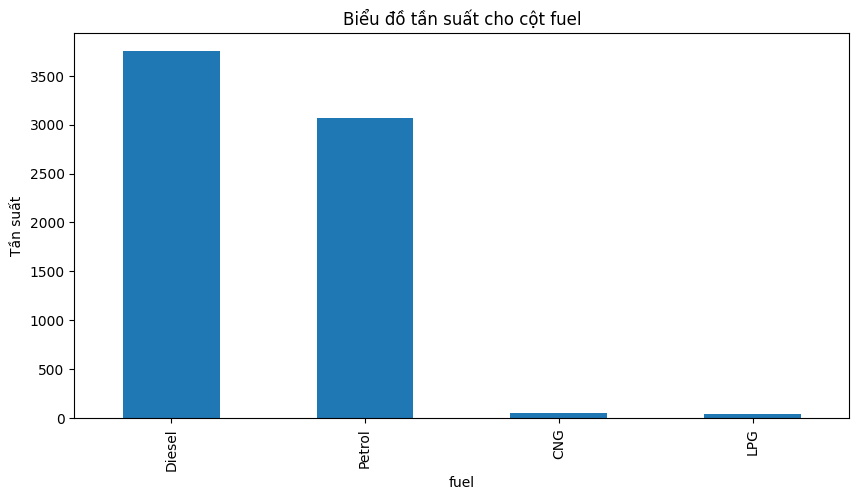

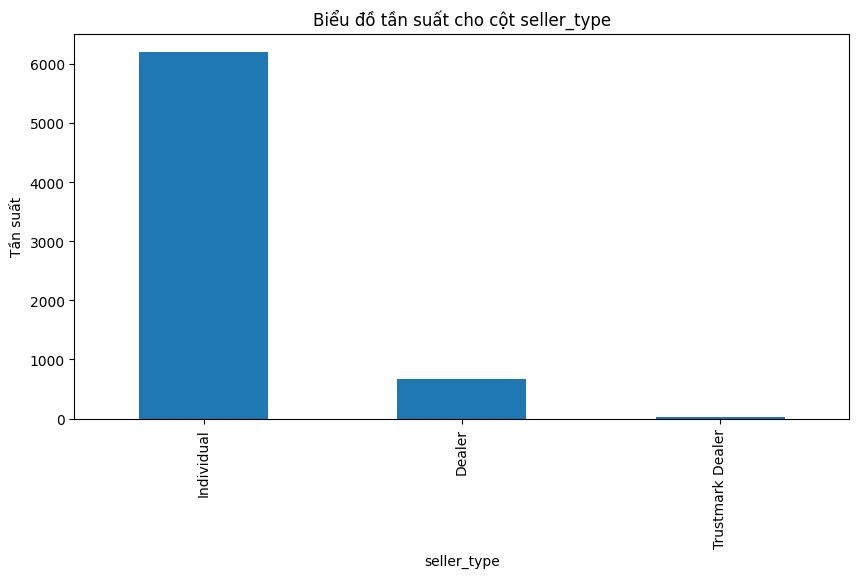

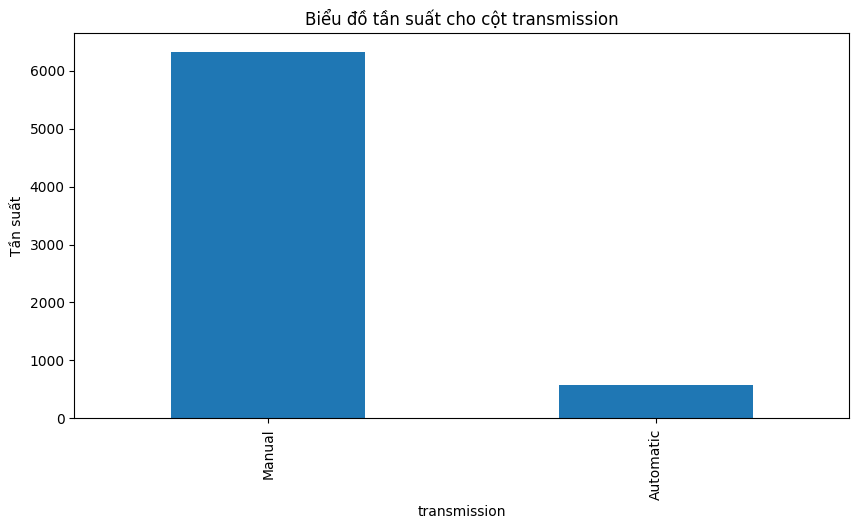

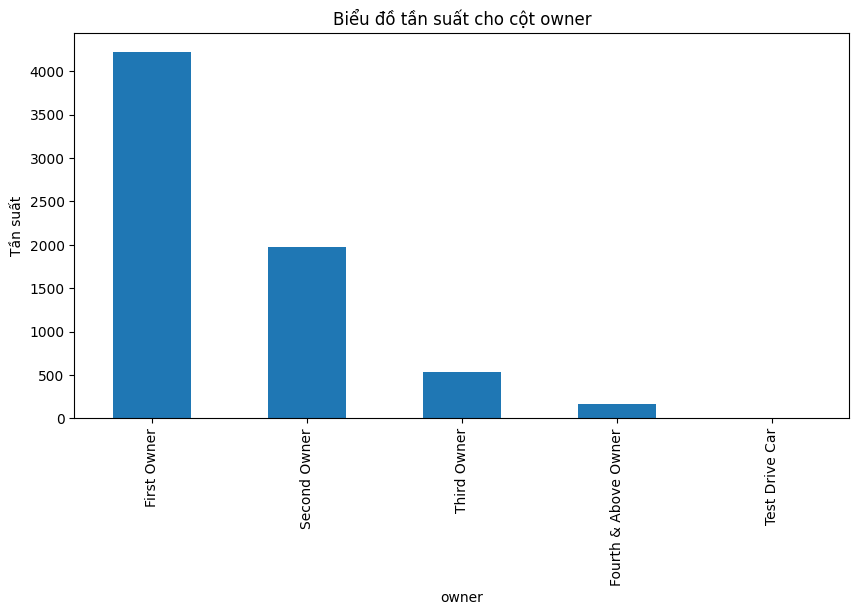

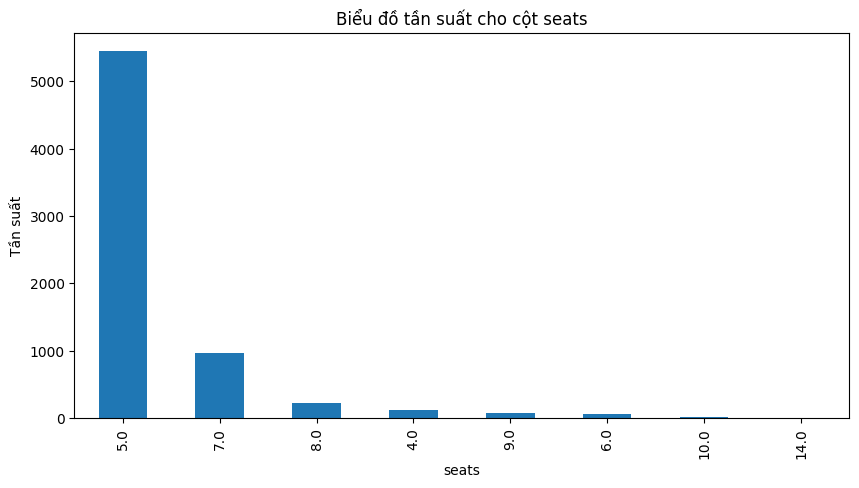

In [15]:
# Vẽ biểu đồ tần suất cho các cột phân loại
for col in dp.categorical_cols:
    plt.figure(figsize=(10, 5))
    dp.df[col].value_counts().plot(kind='bar')
    plt.title(f'Biểu đồ tần suất cho cột {col}')
    plt.xlabel(col)
    plt.ylabel('Tần suất')
    plt.show()

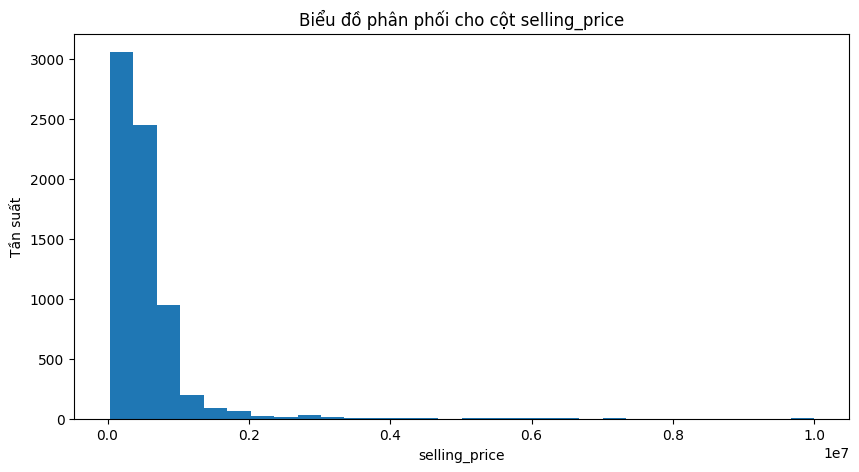

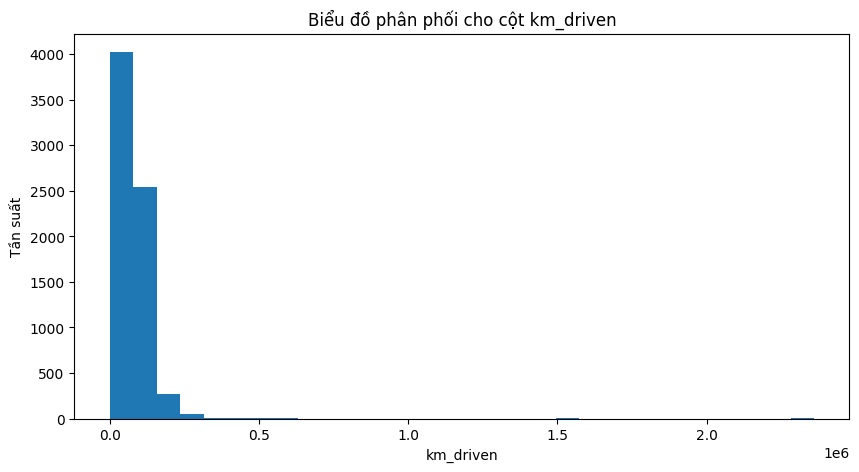

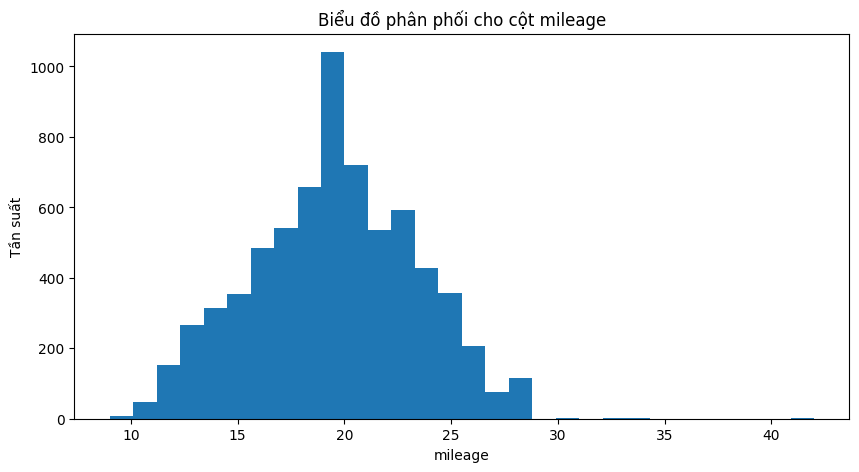

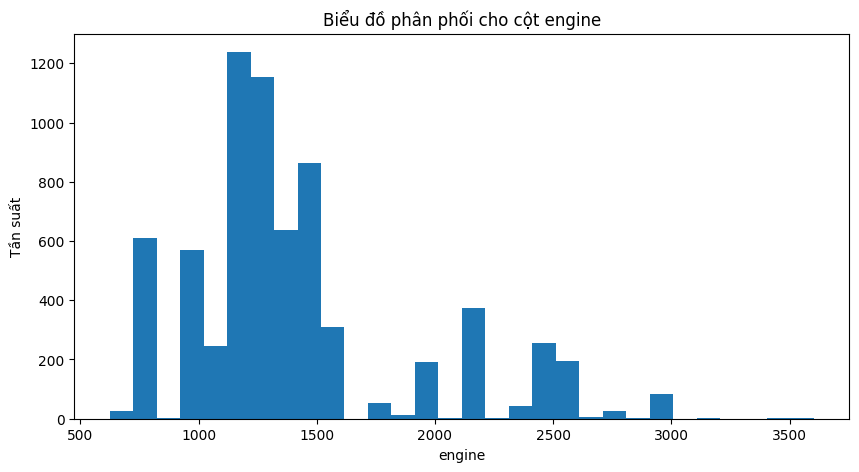

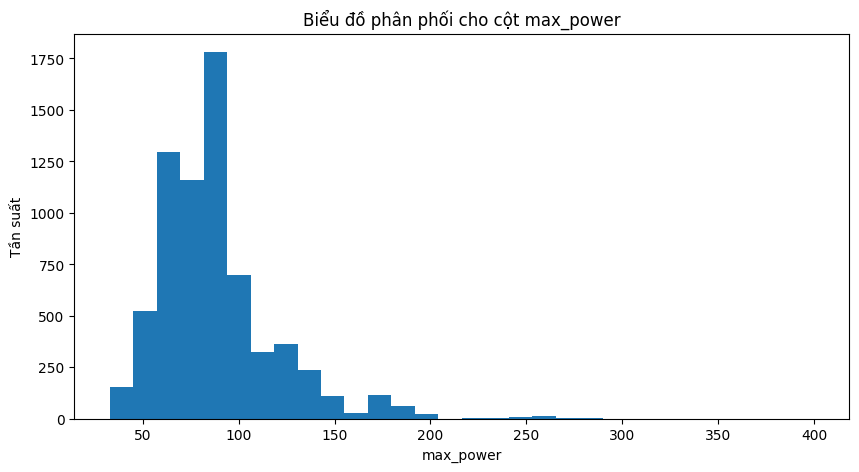

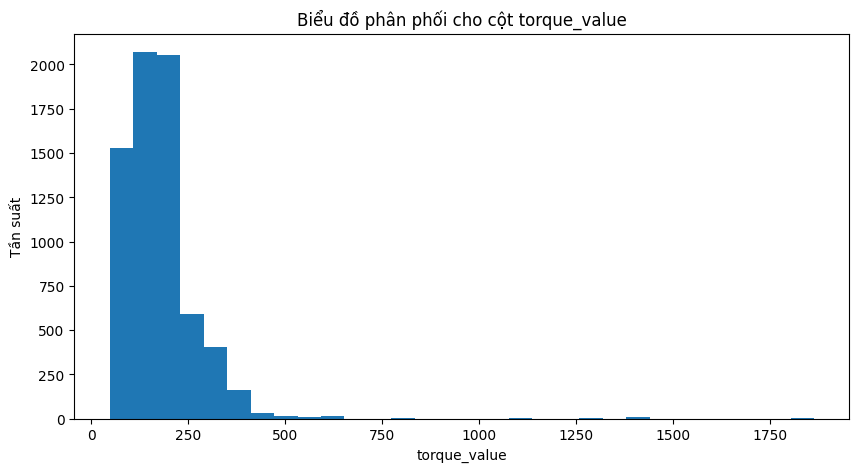

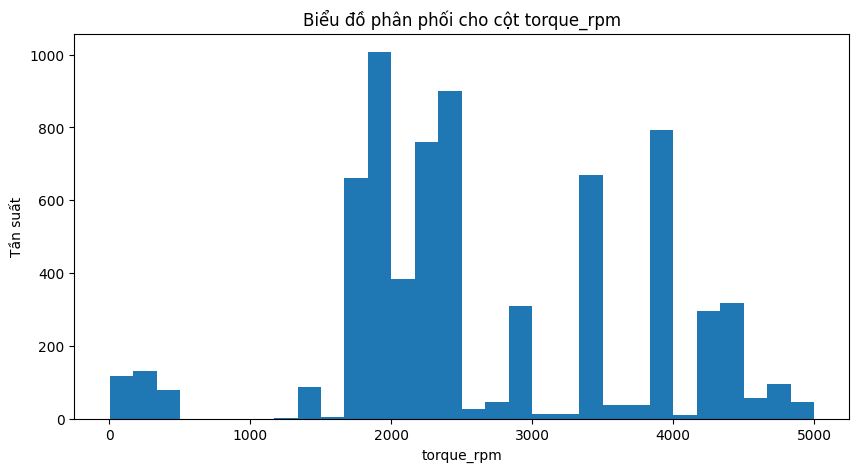

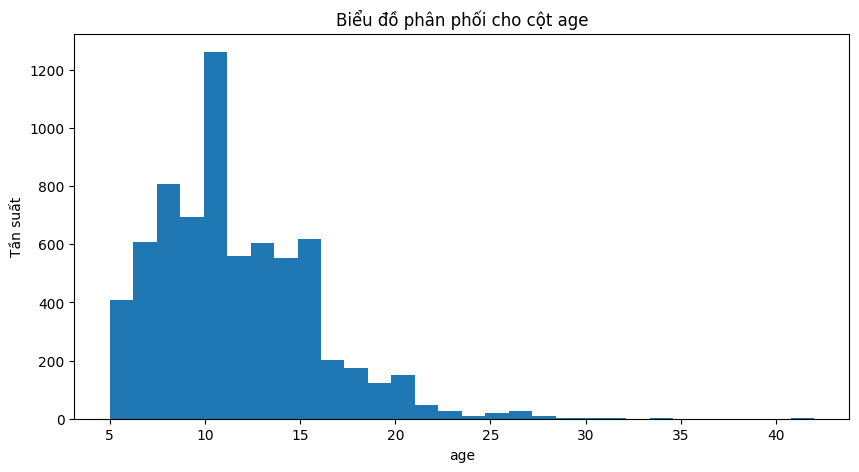

In [16]:
# Vẽ biểu đồ phân phối cho các cột số
for col in dp.numeric_cols:
    plt.figure(figsize=(10, 5))
    dp.df[col].plot(kind='hist', bins=30)
    plt.title(f'Biểu đồ phân phối cho cột {col}')
    plt.xlabel(col)
    plt.ylabel('Tần suất')
    plt.show()

### Xử lý ngoại lai


BÁO CÁO NGOẠI LAI
    Phương pháp: IQR

Cột: selling_price
   - Tổng số giá trị: 6908
   - Số ngoại lai: 325 (4.7%)
   - Độ lệch trung bình so với mean: 1680377.1314
   Nhận xét: Số giá trị ngoại lai bình thường — chấp nhận được.



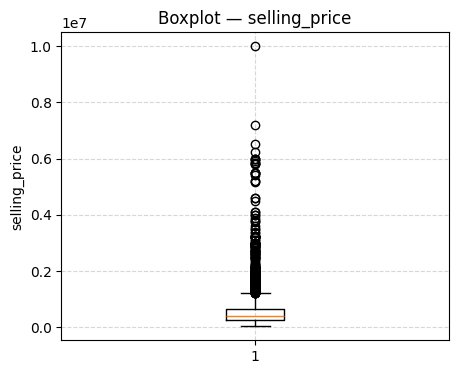

Cột: km_driven
   - Tổng số giá trị: 6908
   - Số ngoại lai: 167 (2.42%)
   - Độ lệch trung bình so với mean: 190901.7225
   Nhận xét: Số giá trị ngoại lai bình thường — chấp nhận được.



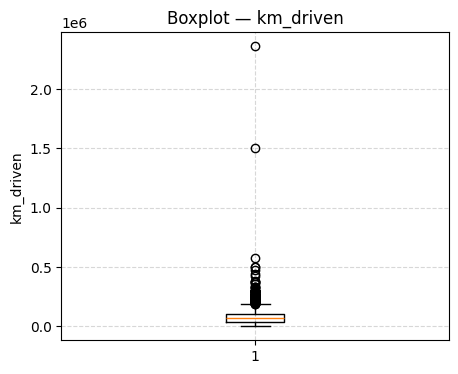

Cột: mileage
   - Tổng số giá trị: 6908
   - Số ngoại lai: 8 (0.12%)
   - Độ lệch trung bình so với mean: 13.9392
   Nhận xét: Ít ngoại lai — không đáng lo ngại.



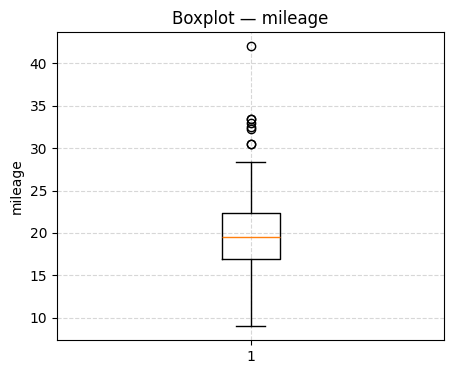

Cột: engine
   - Tổng số giá trị: 6908
   - Số ngoại lai: 1202 (17.4%)
   - Độ lệch trung bình so với mean: 932.2986
   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.



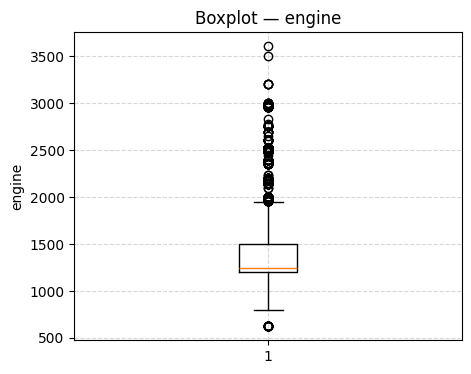

Cột: max_power
   - Tổng số giá trị: 6908
   - Số ngoại lai: 369 (5.34%)
   - Độ lệch trung bình so với mean: 89.2238
   Nhận xét: Nhiều ngoại lai — có thể ảnh hưởng mô hình.



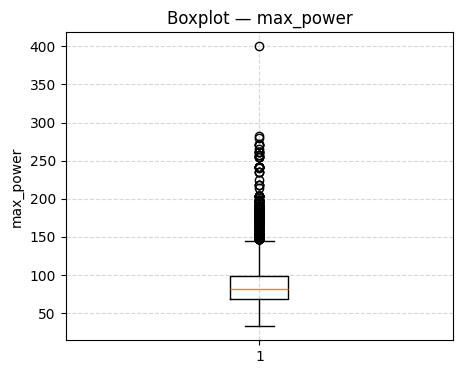

Cột: torque_value
   - Tổng số giá trị: 6908
   - Số ngoại lai: 304 (4.4%)
   - Độ lệch trung bình so với mean: 296.2411
   Nhận xét: Số giá trị ngoại lai bình thường — chấp nhận được.



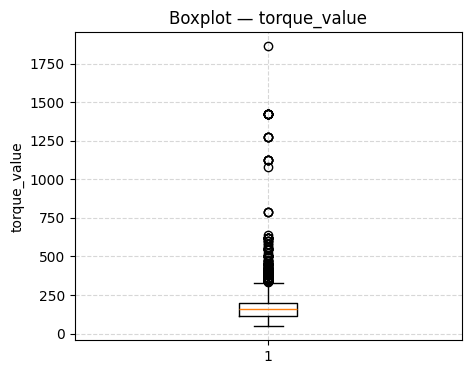

Cột: torque_rpm
   - Tổng số giá trị: 6908
   - Số ngoại lai: 0 (0.0%)
   Không phát hiện ngoại lai.



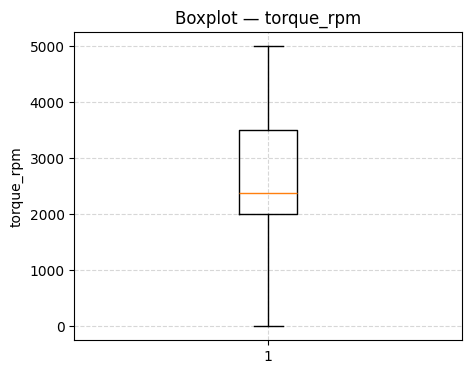

Cột: age
   - Tổng số giá trị: 6908
   - Số ngoại lai: 77 (1.11%)
   - Độ lệch trung bình so với mean: 15.0719
   Nhận xét: Số giá trị ngoại lai bình thường — chấp nhận được.



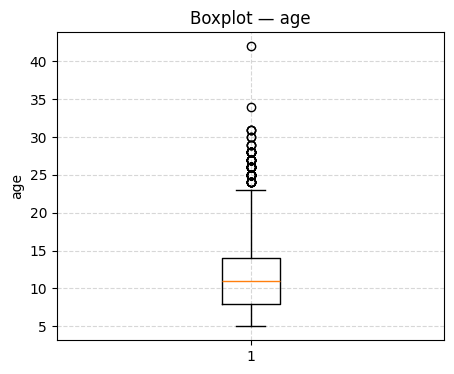

{'selling_price': {'total': 6908,
  'outliers': 325,
  'percent': 4.7,
  'mean_difference': np.float64(1680377.1314)},
 'km_driven': {'total': 6908,
  'outliers': 167,
  'percent': 2.42,
  'mean_difference': np.float64(190901.7225)},
 'mileage': {'total': 6908,
  'outliers': 8,
  'percent': 0.12,
  'mean_difference': np.float64(13.9392)},
 'engine': {'total': 6908,
  'outliers': 1202,
  'percent': 17.4,
  'mean_difference': np.float64(932.2986)},
 'max_power': {'total': 6908,
  'outliers': 369,
  'percent': 5.34,
  'mean_difference': np.float64(89.2238)},
 'torque_value': {'total': 6908,
  'outliers': 304,
  'percent': 4.4,
  'mean_difference': np.float64(296.2411)},
 'torque_rpm': {'total': 6908,
  'outliers': 0,
  'percent': 0.0,
  'mean_difference': 0},
 'age': {'total': 6908,
  'outliers': 77,
  'percent': 1.11,
  'mean_difference': np.float64(15.0719)}}

In [17]:
# Tìm và đánh giá ngoại lai
dp.detect_outliers(method="iqr")

Các giá trị ngoại lai này có thể giữ nguyên do không phải do sai xót nhập liệu, hay vô lý, có thể biểu đạt tính chất của đối tượng.   
Nhưng để tránh bị ảnh hưởng do các giá trị quá lớn, sẽ xóa các giá trị quá lớn của cột selling_price, km_driven, mileage, max_power, torque_value.

In [18]:
# Xóa các giá trị quá lớn của cột selling_price, km_driven, mileage, max_power, torque_value
outlier_thresholds = {
    "selling_price": 8000000,
    "km_driven": 1000000,
    "mileage": 35,
    "max_power": 300,
    "torque_value": 750
}
for col, threshold in outlier_thresholds.items():
    dp.df = dp.df[dp.df[col] <= threshold]
dp

<class 'pandas.core.frame.DataFrame'>
Index: 6881 entries, 0 to 6907
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6881 non-null   object 
 1   selling_price  6881 non-null   int64  
 2   km_driven      6881 non-null   int64  
 3   fuel           6881 non-null   object 
 4   seller_type    6881 non-null   object 
 5   transmission   6881 non-null   object 
 6   owner          6881 non-null   object 
 7   mileage        6881 non-null   float64
 8   engine         6881 non-null   float64
 9   max_power      6881 non-null   float64
 10  seats          6881 non-null   float64
 11  torque_value   6881 non-null   float64
 12  torque_rpm     6881 non-null   float64
 13  age            6881 non-null   int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 806.4+ KB


None

### Chuẩn hóa dữ liệu số và phân loại

In [19]:
# Chuẩn hóa dữ liệu số
dp.scale_numeric(method="standard")

Sử dụng StandardScaler (Chuẩn hóa Z-score)
Đã chuẩn hóa 8 cột số: ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque_value', 'torque_rpm', 'age']
<class 'pandas.core.frame.DataFrame'>
Index: 6881 entries, 0 to 6907
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6881 non-null   object 
 1   selling_price  6881 non-null   float64
 2   km_driven      6881 non-null   float64
 3   fuel           6881 non-null   object 
 4   seller_type    6881 non-null   object 
 5   transmission   6881 non-null   object 
 6   owner          6881 non-null   object 
 7   mileage        6881 non-null   float64
 8   engine         6881 non-null   float64
 9   max_power      6881 non-null   float64
 10  seats          6881 non-null   float64
 11  torque_value   6881 non-null   float64
 12  torque_rpm     6881 non-null   float64
 13  age            6881 non-null   float64
dtypes: float64(9), object

None

In [20]:
# Xuất ra các giá trị khác nhau của cột phân loại
for col in dp.categorical_cols:
    unique_values = dp.df[col].unique()
    print(f"Các giá trị khác nhau của cột '{col}': {unique_values}")

Các giá trị khác nhau của cột 'fuel': ['Diesel' 'Petrol' 'LPG' 'CNG']
Các giá trị khác nhau của cột 'seller_type': ['Individual' 'Dealer' 'Trustmark Dealer']
Các giá trị khác nhau của cột 'transmission': ['Manual' 'Automatic']
Các giá trị khác nhau của cột 'owner': ['First Owner' 'Second Owner' 'Third Owner' 'Fourth & Above Owner'
 'Test Drive Car']
Các giá trị khác nhau của cột 'seats': [ 5.  4.  7.  8.  6.  9. 10. 14.]


Không phát hiện bất thường.

In [21]:
# Chuyển dữ liệu phân loại thành số
dp.encode_categories(method="label")

<class 'pandas.core.frame.DataFrame'>
Index: 6881 entries, 0 to 6907
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6881 non-null   object 
 1   selling_price  6881 non-null   float64
 2   km_driven      6881 non-null   float64
 3   fuel           6881 non-null   int64  
 4   seller_type    6881 non-null   int64  
 5   transmission   6881 non-null   int64  
 6   owner          6881 non-null   int64  
 7   mileage        6881 non-null   float64
 8   engine         6881 non-null   float64
 9   max_power      6881 non-null   float64
 10  seats          6881 non-null   float64
 11  torque_value   6881 non-null   float64
 12  torque_rpm     6881 non-null   float64
 13  age            6881 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 806.4+ KB


None

### Phân tích mối quan hệ giữa các cột với cột mục tiêu

In [22]:
# Ma trân tương quan của toàn bộ các cột
# Đặt độ chính xác cho màn hình float
pd.set_option('display.float_format', '{:,.3f}'.format)
# Tính toán ma trận tương quan
correlation = dp.df.select_dtypes(include=["number"]).corr()
# Hiển thị ma trận tương quan
correlation

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,torque_value,torque_rpm,age
selling_price,1.000,-0.202,-0.249,-0.253,-0.464,-0.228,-0.129,0.454,0.685,0.176,0.635,-0.089,-0.441
km_driven,-0.202,1.000,-0.332,0.127,0.139,0.298,-0.237,0.294,0.043,0.239,0.176,-0.335,0.442
fuel,-0.249,-0.332,1.000,0.037,-0.029,-0.018,-0.095,-0.507,-0.305,-0.344,-0.677,0.688,0.065
seller_type,-0.253,0.127,0.037,1.000,0.178,0.144,-0.013,-0.072,-0.184,0.026,-0.144,-0.006,0.129
transmission,-0.464,0.139,-0.029,0.178,1.000,0.079,0.173,-0.218,-0.436,0.016,-0.306,-0.070,0.140
owner,-0.228,0.298,-0.018,0.144,0.079,1.000,-0.173,0.027,-0.055,-0.000,-0.035,-0.146,0.451
mileage,-0.129,-0.237,-0.095,-0.013,0.173,-0.173,1.000,-0.593,-0.402,-0.481,-0.264,0.017,-0.350
engine,0.454,0.294,-0.507,-0.072,-0.218,0.027,-0.593,1.000,0.689,0.666,0.755,-0.359,0.000
max_power,0.685,0.043,-0.305,-0.184,-0.436,-0.055,-0.402,0.689,1.000,0.268,0.853,-0.136,-0.159
seats,0.176,0.239,-0.344,0.026,0.016,-0.000,-0.481,0.666,0.268,1.000,0.402,-0.242,-0.046


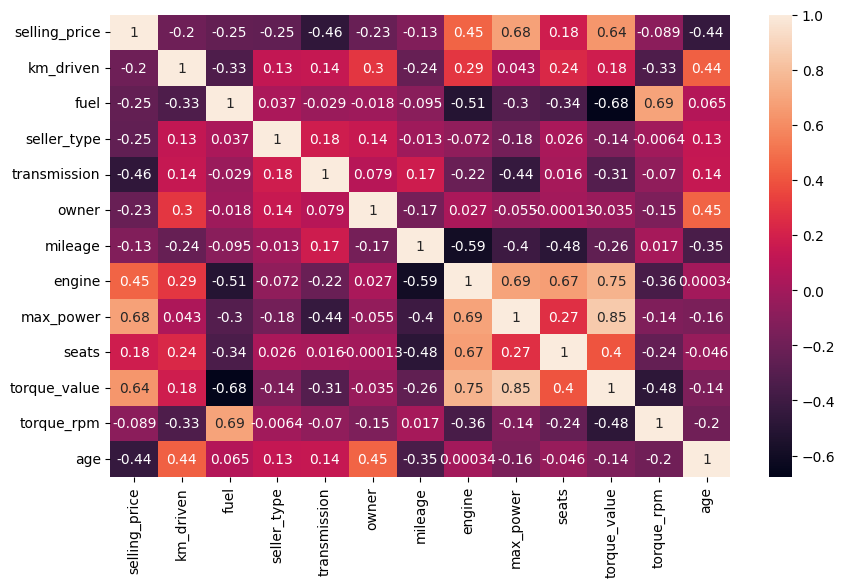

In [23]:
# Vẽ ma trận tương quan trong heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(correlation, ax=ax, annot=True)
plt.show()

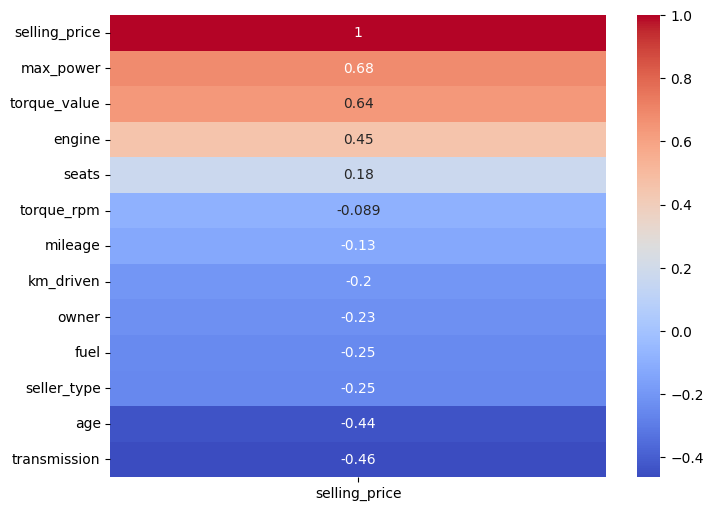

In [24]:
# Vẽ ma trận tương quan theo biến mục tiêu (price)
target_correlation = dp.df.drop(columns=["name"]).corr()[dp.target].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.heatmap(target_correlation.to_frame(), annot=True, cmap="coolwarm")
plt.show()

## Xuất file dữ liệu đã xử lý

In [25]:
# Xuất file đã xử lý
dp.save("data_processed.csv", "data_encoders.csv")

✔ Đã lưu dataframe tại: data_processed.csv
Đã lưu encoders tại: data_encoders.csv
